In [1]:
# Useful import
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.cm import tab10

import seaborn as sns

import pint
ureg = pint.UnitRegistry()

In [2]:
# My tools
from mdb.database.standard_configs import create_strucutre
from mdb.parsers import PosFileParser
from yapc.tools import LammpsForceModifier
from yapc.dynamical_matrix import Phonon

In [3]:
# fix loggers
import logging
import sys

logger=logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [4]:
relaxed_alat = 5.43094977841313
my_conf = create_strucutre('Diamond2', relaxed_alat)
n_atoms = my_conf.n_atoms

In [5]:
confs = []
for x in range(n_atoms):
    for label, j in [('x',None), ('y',None), ('z',None)]:
        conf = next(PosFileParser(f'forces/{x}/{label}/forces.dat'))
        mconf = next(PosFileParser(f'forces/{x}/-{label}/forces.dat'))
        confs.append((conf,mconf))

velocities not available
velocities not available
velocities not available
velocities not available
velocities not available
velocities not available
velocities not available
velocities not available
velocities not available
velocities not available
velocities not available
velocities not available


In [6]:
p = Phonon(my_conf, (4,4,4))

In [7]:
lfm = LammpsForceModifier(my_conf._multiply(4,4,4).cell)
dyn_mat_r = p.dynamical_matrix_real(confs, force_modifier=lfm)

sum over all atoms b is not zero: 0.000072


In [8]:
before, after = p.apply_acoustic_sum_rule()
print(f'{before:2.2e} -> {after:2.2e} ev/A^2')

7.18e-05 -> 7.34e-06 ev/A^2


In [9]:
xg = np.linspace((.5,0,.5), (0,0,0), 100) @ my_conf.cell.reciprocal * 2 * 3.14
gl = np.linspace((0,0,0), (.5, .5, .5), 100) @ my_conf.cell.reciprocal * 2 * 3.14
lx = np.linspace((.5, .5, .5), (.5, 0, .5), 100) @ my_conf.cell.reciprocal * 2 * 3.14

In [10]:
# path
sampling = []

for q in xg:
    w, v = p(q)
    w.sort()
    sampling.append((-np.linalg.norm(q), w))
for q in gl:
    w, v = p(q)
    w.sort()
    sampling.append((np.linalg.norm(q), w))
zero = np.linalg.norm(q)
for q in lx:
    w, v = p(q)
    w.sort()
    d = zero + np.linalg.norm(q - gl[-1])
    sampling.append((d, w))

/home/ruggero/Dottorato/projects_code/panna_prerelease/.venv/lib/python3.9/site-packages/pint/numpy_func.py:303: RuntimeWarning: invalid value encountered in sqrt
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/home/ruggero/Dottorato/projects_code/panna_prerelease/.venv/lib/python3.9/site-packages/pint/quantity.py:1237: RuntimeWarning: divide by zero encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


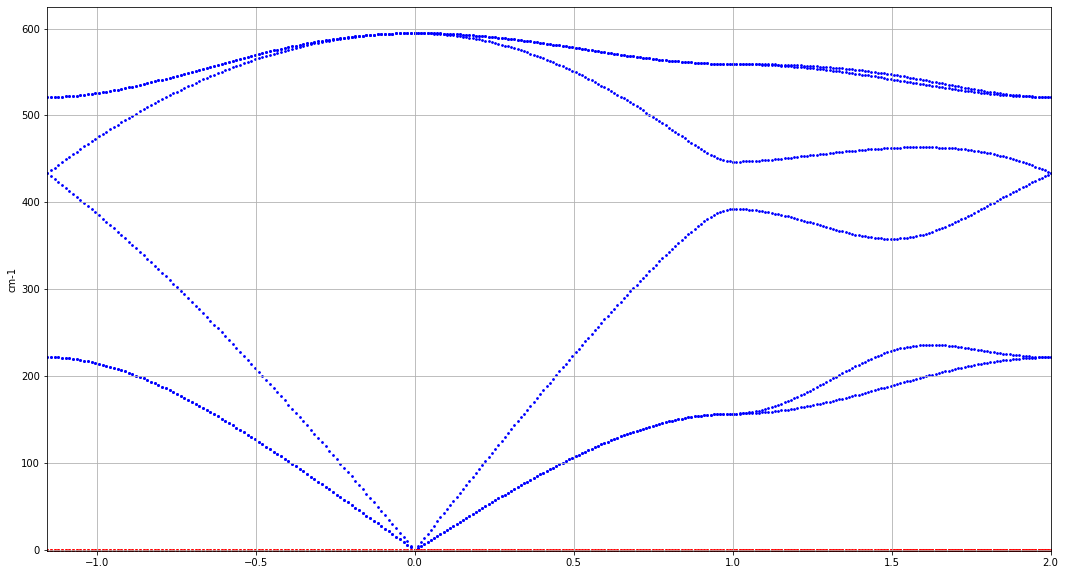

In [11]:
fig, axes = plt.subplots(1,1, figsize=(18,10))

def _convert(y):
    data = y.copy()
    data[data<0] = 0
    data = y * ureg.electron_volt/ureg.angstrom**2
    data = np.sqrt(data/(28.0855 * ureg.atomic_mass_constant))
    data /= (np.pi * 2)
    data = data.to(ureg.cm_1, 'sp').magnitude 
    return data

for x, y in sampling:
    y_r = np.real(y)
    y_im = np.imag(y)
    y_r = _convert(y_r)
    y_im = _convert(y_im)
    axes.scatter([x] * len(y), y_r, c='blue', s=3)
    axes.scatter([x] * len(y), y_im, c='red', s=3)
axes.set_xlim(sampling[0][0], sampling[-1][0])
axes.set_ylim(-1)
axes.set_ylabel('cm-1')
axes.grid()

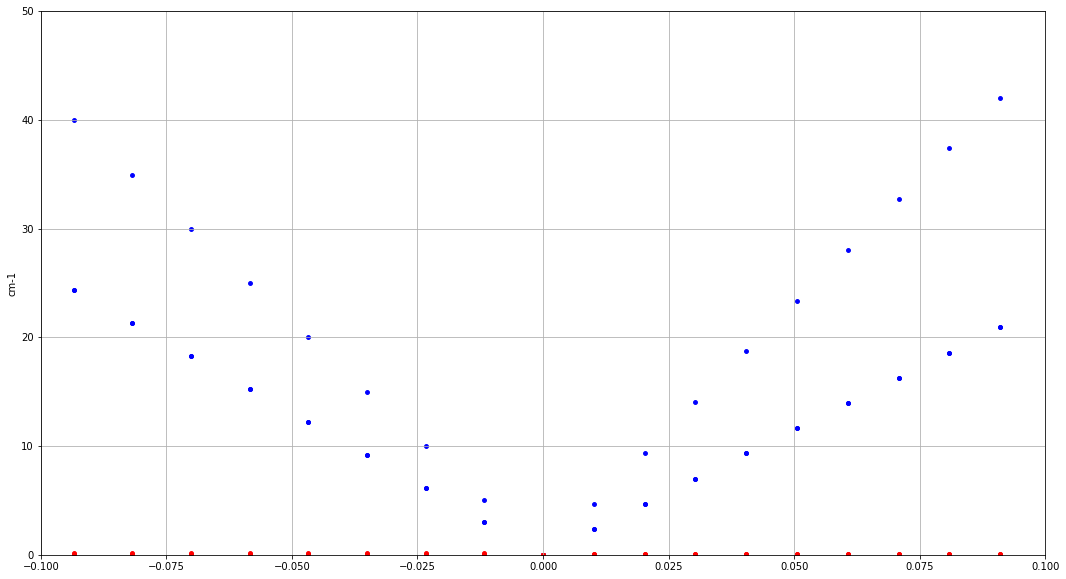

In [12]:
fig, axes = plt.subplots(1,1, figsize=(18,10))
for x, y in sampling:
    y_r = np.real(y)
    y_im = np.imag(y)
    y_r = _convert(y_r)
    y_im = _convert(y_im)
    axes.scatter([x] * len(y), y_r, c='blue', s=15)
    axes.scatter([x] * len(y), y_im, c='red', s=15)    
axes.set_xlim(-.1, .1)
axes.set_ylim(-.01, 50)
axes.set_ylabel('cm-1')
axes.grid()

In [13]:
print(p.performance)

compute weights: 20.78 msec
call: 0.77 \pm 0.33 msec
average over 298 samples


In [14]:
# test points on the BW surface I will test only few symmetries
# that come to my mind

points = {
    'K': [(3/8, 3/8, 3/4),()],
    'L': [(1/2, 1/2, 1/2),((1, 1, 1))],
    'U': [(5/8, 1/4, 5/8),()],
    'W': [(1/2, 1/4, 3/4),(1, 0, 1)],
    'X': [(1/2, 0  , 1/2),((1, 1, 0), (0, 1, 1), (1, 0, 1), (-1, -1, 0), (1, -1, 0))]
}

In [15]:
def _eigen(kp):
    w, _ = p(kp * 2 * 3.14)
    w.sort()
    return np.real(w)
    
for k, (v, trans) in points.items():
    pa = np.array(v)
    kp = pa @ my_conf.cell.reciprocal
    ref = _eigen(kp)
    for t in trans:
        test = _eigen((pa - np.array(t))@ my_conf.cell.reciprocal)
        if (test := np.abs(ref-test).max()) > 1e-4:
            print(f'!E - {k} - {t}: {test:2.2e}')
print('OK!')

OK!


In [16]:
nx, ny, nz = (20j, 20j, 20j)
grid = np.mgrid[-.5:.5:nx, -.5:.5:ny, -.5:.5:nz].T

In [17]:
grid = grid.reshape(-int(np.imag(nx * ny * nz)), 3)

In [18]:
print(f'{p.predict_time(len(grid)):2.2} sec')

6.4 sec


In [19]:
%%time
out = []
for row in grid:
    row = row @ my_conf.cell.reciprocal * 2 * 3.14
    v, _ = p(row)
    v.sort()
    v = np.real(v)
    out.append(v)
    

CPU times: user 10.5 s, sys: 13 s, total: 23.5 s
Wall time: 7.86 s


In [20]:
data = np.vstack(out).flatten()
# add units
data = data * ureg.electron_volt/ureg.angstrom**2
data = np.sqrt(data/(28.086 * ureg.atomic_mass_constant))
data /= (np.pi * 2)
data = data.to(ureg.cm_1, 'sp').magnitude

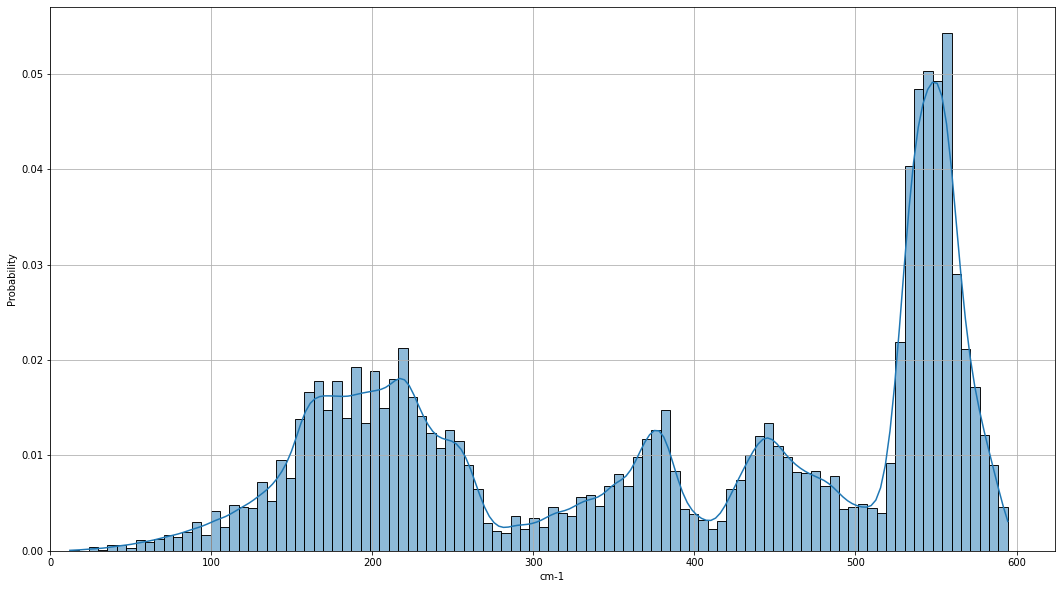

In [45]:
fig, axes = plt.subplots(1,1, figsize=(18,10))
sns.histplot(data, bins = 100, stat='probability', kde=True, kde_kws={'bw_adjust': .35})
axes.set_xlim(0)
axes.set_xlabel('cm-1')
plt.grid()

In [22]:
# Participation ration
v, w = p()

In [23]:
p_ratio = np.sqrt(1/np.sum(w**4, axis=0))

In [24]:
# p_ratio = np.sum(w, axis=0)**2/np.sum(w**2, axis=0)

In [25]:
# p_ratio

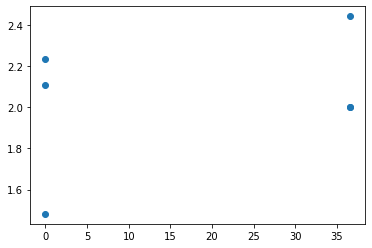

In [26]:
plt.scatter(v, p_ratio)

In [27]:
# projected v-dos

In [28]:
def gauss(x, x0=0, sigma=1):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - x0)**2 / (2 * sigma**2))

In [29]:
v[v<0] =0

In [30]:
# add units
v = v * ureg.electron_volt/ureg.angstrom**2
v = np.sqrt(v/(28.086 * ureg.atomic_mass_constant))
v /= (np.pi * 2)
v = v.to(ureg.cm_1, 'sp').magnitude

In [31]:
l_sample = np.linspace(0,650, 600)
sample = l_sample[:,np.newaxis] - v
sample = sample.T
sample = gauss(sample, 0, 20)
out = (np.sum(w.reshape(3,2,6)**2, axis = 0)[..., np.newaxis] - sample)
out = out.sum(axis=1)

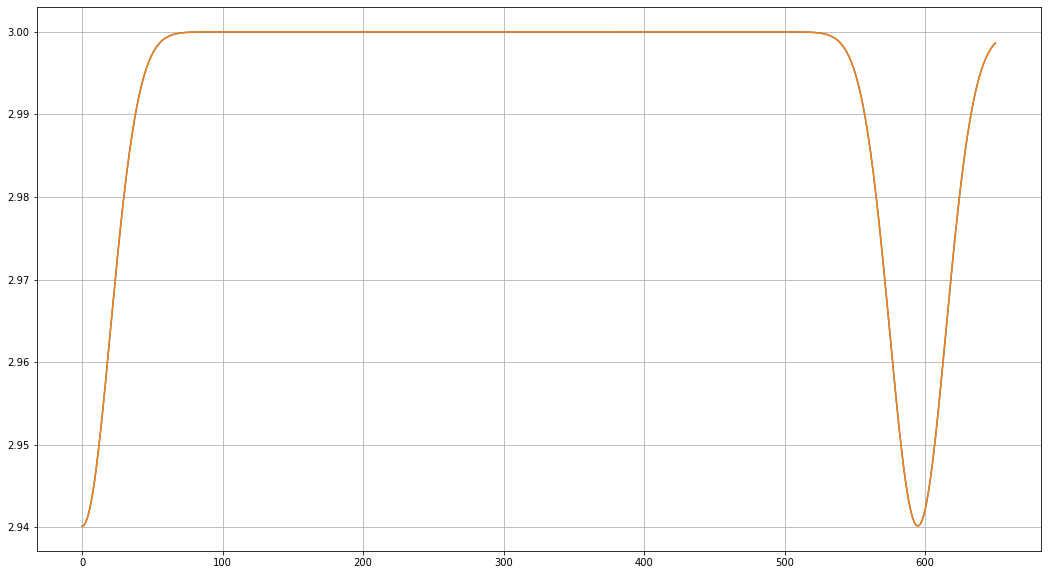

In [32]:
fig, axes = plt.subplots(1,1, figsize=(18,10))
for x in out:
    plt.plot(l_sample, x)
plt.grid()